In [1]:
import os
import boto3
import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.ml.image import ImageSchema
import cv2
from PIL import Image

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .getOrCreate()

spark.conf.set("spark.sql.execution.arrow.enabled", "true")

In [2]:
import random
import numpy as np
from scipy.ndimage import affine_transform
from keras.preprocessing.image import img_to_array
from keras import backend as K

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
PATH = 'tank_pic.jpg'

In [4]:
images = ImageSchema.readImages(PATH, recursive = True)

In [5]:
images.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = false)
 |    |-- width: integer (nullable = false)
 |    |-- nChannels: integer (nullable = false)
 |    |-- mode: integer (nullable = false)
 |    |-- data: binary (nullable = false)



image index: single
image type: <class 'pyspark.sql.types.Row'>, number of fields: 6
image path: file:/C:/Users/John Morin/Documents/GitHub/Spark_Image_Classification/tank_pic.jpg
height: 540, width: 960, OpenCV type: 16


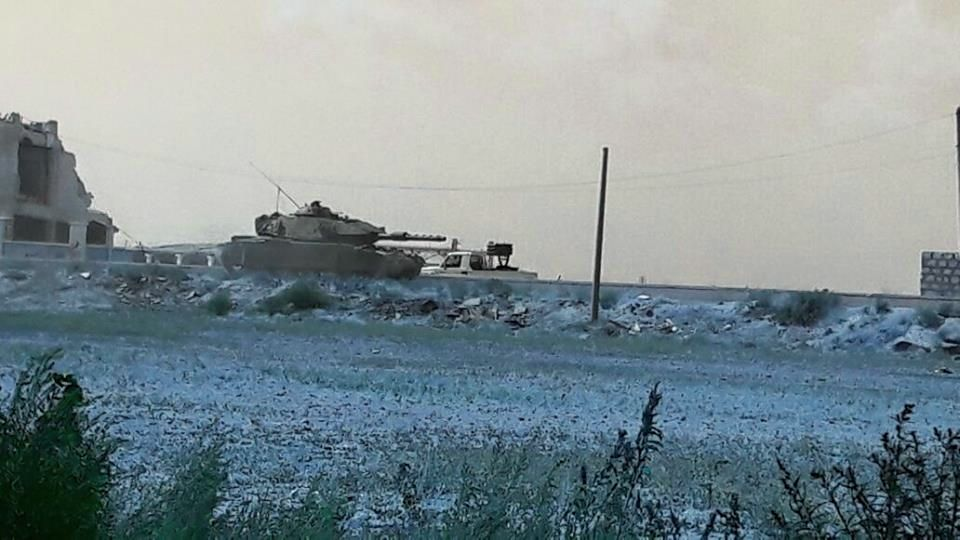

In [6]:
one_image = images.first()
mine = one_image[0]
print("image index: {}".format('single'))
print("image type: {}, number of fields: {}".format(type(mine), len(mine)))
print("image path: {}".format(mine.origin))
print("height: {}, width: {}, OpenCV type: {}".format(mine.height, mine.width, mine.mode))

arr = ImageSchema.toNDArray(mine)     # convert to numpy array
Image.fromarray(arr, "RGB")   # display the image inside notebook

In [7]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [8]:
x = 213
y = 196
w = 237
h = 87

blah = Image.fromarray(arr, "RGB")

open_cv_image = np.array(blah) 
# Convert RGB to BGR 
open_cv_image = open_cv_image[:, :, ::-1].copy()

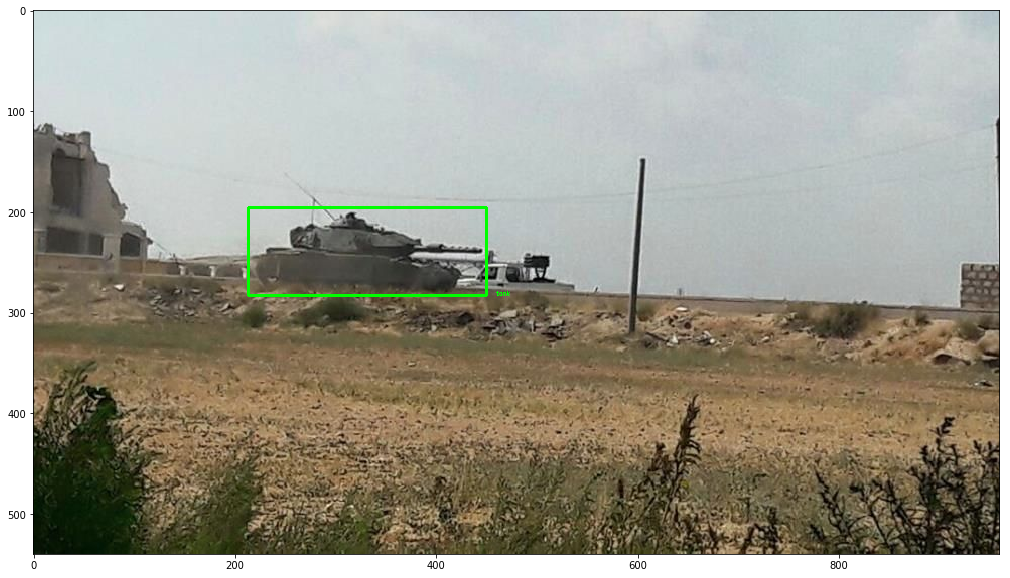

In [9]:
cv2.rectangle(open_cv_image, (x,y),(x+w,y+h), (0,255,0),2)
cv2.putText(open_cv_image, 'tank', (x+w+10,y+h),0,0.2,(0,255,0))
#cv2.imshow('image', open_cv_image)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

plt.figure(figsize=(20,10))
plt.imshow(open_cv_image)

In [10]:
img_shape  = (540,960,3)
anisotropy = 2.15

def build_transform(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    rotation        = np.deg2rad(rotation)
    shear           = np.deg2rad(shear)
    rotation_matrix = np.array([[np.cos(rotation), np.sin(rotation), 0], [-np.sin(rotation), np.cos(rotation), 0], [0, 0, 1]])
    shift_matrix    = np.array([[1, 0, height_shift], [0, 1, width_shift], [0, 0, 1]])
    shear_matrix    = np.array([[1, np.sin(shear), 0], [0, np.cos(shear), 0], [0, 0, 1]])
    zoom_matrix     = np.array([[1.0/height_zoom, 0, 0], [0, 1.0/width_zoom, 0], [0, 0, 1]])
    shift_matrix    = np.array([[1, 0, -height_shift], [0, 1, -width_shift], [0, 0, 1]])
    return np.dot(np.dot(rotation_matrix, shear_matrix), np.dot(zoom_matrix, shift_matrix))

# Compute the coordinate transformation required to center the pictures, padding as required.
def center_transform(affine, input_shape):
    hi, wi = float(input_shape[0]), float(input_shape[1])
    ho, wo = float(img_shape[0]), float(img_shape[1])
    top, left, bottom, right = 0, 0, hi, wi
    if wi/hi/anisotropy < wo/ho: # input image too narrow, extend width
        w     = hi*wo/ho*anisotropy
        left  = (wi-w)/2
        right = left + w
    else: # input image too wide, extend height
        h      = wi*ho/wo/anisotropy
        top    = (hi-h)/2
        bottom = top + h
    center_matrix   = np.array([[1, 0, -ho/2], [0, 1, -wo/2], [0, 0, 1]])
    scale_matrix    = np.array([[(bottom - top)/ho, 0, 0], [0, (right - left)/wo, 0], [0, 0, 1]])
    decenter_matrix = np.array([[1, 0, hi/2], [0, 1, wi/2], [0, 0, 1]])
    return np.dot(np.dot(decenter_matrix, scale_matrix), np.dot(affine, center_matrix))

# Apply an affine transformation to an image represented as a numpy array.
def transform_img(x, affine):
    matrix   = affine[:2,:2]
    offset   = affine[:2,2]
    x        = np.moveaxis(x, -1, 0)
    channels = [affine_transform(channel, matrix, offset, output_shape=img_shape[:-1], order=1,
                                 mode='constant', cval=np.average(channel)) for channel in x]
    return np.moveaxis(np.stack(channels, axis=0), 0, -1)

def read_for_training(p):
    # changed to use opencv instead of PIL
    # x  = read_array(p)
    x = p
    t  = build_transform(
            random.uniform(-5, 5),
            random.uniform(-5, 5),
            random.uniform(0.9, 1.0),
            random.uniform(0.9, 1.0),
            random.uniform(-0.05*img_shape[0], 0.05*img_shape[0]),
            random.uniform(-0.05*img_shape[1], 0.05*img_shape[1]))
    t  = center_transform(t, x.shape)
    x  = transform_img(x, t)
    x = x - np.mean(x, keepdims=True)
    x /= np.std(x, keepdims=True) + K.epsilon()
    return x,t   

In [11]:
read_for_training(open_cv_image)

(array([[[ 0.17388628,  0.10031316, -0.26755245],
         [ 0.17388628,  0.10031316, -0.26755245],
         [ 0.17388628,  0.10031316, -0.26755245],
         ...,
         [ 0.17388628,  0.10031316, -0.26755245],
         [ 0.17388628,  0.10031316, -0.26755245],
         [ 0.17388628,  0.10031316, -0.26755245]],
 
        [[ 0.17388628,  0.10031316, -0.26755245],
         [ 0.17388628,  0.10031316, -0.26755245],
         [ 0.17388628,  0.10031316, -0.26755245],
         ...,
         [ 0.17388628,  0.10031316, -0.26755245],
         [ 0.17388628,  0.10031316, -0.26755245],
         [ 0.17388628,  0.10031316, -0.26755245]],
 
        [[ 0.17388628,  0.10031316, -0.26755245],
         [ 0.17388628,  0.10031316, -0.26755245],
         [ 0.17388628,  0.10031316, -0.26755245],
         ...,
         [ 0.17388628,  0.10031316, -0.26755245],
         [ 0.17388628,  0.10031316, -0.26755245],
         [ 0.17388628,  0.10031316, -0.26755245]],
 
        ...,
 
        [[ 0.17388628,  0.10031316

In [20]:
from pyspark.ml.pipeline import Estimator, Model, Pipeline
from pyspark.ml.param.shared import *
from pyspark.sql.functions import avg, stddev_samp

In [ ]:
from scipy.misc import toimage

In [21]:
class HasVector(Params):

    array = Param(Params._dummy(), "vector", "vector", 
        typeConverter=TypeConverters.toVector)

    def __init__(self):
        super(HasArray, self).__init__()

    def setVector(self, value):
        return self._set(array=value)

    def getVector(self):
        return self.getOrDefault(self.array)

In [22]:
class HasAnisotropy(Params):
    anisotropy = Param(Params._dummy(), 'anisotropy', 'anisotropy',
        typeConverter= TypeConverters.toFloat)
    
    def __init__(self):
        super(HasAnisotropy, self).__init__()
    
    def setAnisotropy(self, value):
        return self._set(anisotropy=value)
    
    def getAnisotropy(self):
        return self.getOrDefault(self.anisotropy)

    # Look into adding default value?

In [23]:
class HasImgShape(Params):
    img_shape = Param(Params._dummy(), 'img_shape', 'img_shape',
        typeConverter= TypeConverters.toList)
    
    def __init__(self):
        super(HasImgShape, self).__init__()
    
    def setImgShape(self, value):
        return self._set(img_shape=value)
    
    def getImgShape(self):
        return self.getOrDefault(self.img_shape)
    
    # Look into adding default value?

In [25]:
class HasCenteredThreshold(Params):

    centered_threshold = Param(Params._dummy(),
            "centered_threshold", "centered_threshold",
            typeConverter=TypeConverters.toFloat)

    def __init__(self):
        super(HasCenteredThreshold, self).__init__()

    def setCenteredThreshold(self, value):
        return self._set(centered_threshold=value)

    def getCenteredThreshold(self):
        return self.getOrDefault(self.centered_threshold)

In [52]:
class AffineTransform(Estimator, HasInputCol, 
        HasFeaturesCol, HasImgShape, HasAnisotropy):

    def _fit(self, dataset):
        c = self.getInputCol()
        print(c)
        #mu, sigma = dataset.agg(avg(c), stddev_samp(c)).first()
        return (AffineTransformModel()
            .setInputCol(c)
            .setImgShape(self.getImgShape())
            .setAnisotropy(self.getAnisotropy())
            .setFeaturesCol(self.getFeaturesCol()))
    
    
class AffineTransformModel(Model, HasInputCol,
        HasFeaturesCol, HasImgShape, HasAnisotropy):

    def _transform(self, dataset):
        x = self.getInputCol()
        y = self.getFeaturesCol()
        anisotropy = self.getAnisotropy()
        img_shape = self.getImgShape()
        return dataset.withColumn(y, read_for_training(x))
    
    def build_transform(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
        rotation        = np.deg2rad(rotation)
        shear           = np.deg2rad(shear)
        rotation_matrix = np.array([[np.cos(rotation), np.sin(rotation), 0], [-np.sin(rotation), np.cos(rotation), 0], [0, 0, 1]])
        shift_matrix    = np.array([[1, 0, height_shift], [0, 1, width_shift], [0, 0, 1]])
        shear_matrix    = np.array([[1, np.sin(shear), 0], [0, np.cos(shear), 0], [0, 0, 1]])
        zoom_matrix     = np.array([[1.0/height_zoom, 0, 0], [0, 1.0/width_zoom, 0], [0, 0, 1]])
        shift_matrix    = np.array([[1, 0, -height_shift], [0, 1, -width_shift], [0, 0, 1]])
        return np.dot(np.dot(rotation_matrix, shear_matrix), np.dot(zoom_matrix, shift_matrix))

    # Compute the coordinate transformation required to center the pictures, padding as required.
    def center_transform(affine, input_shape):
        hi, wi = float(input_shape[0]), float(input_shape[1])
        ho, wo = float(img_shape[0]), float(img_shape[1])
        top, left, bottom, right = 0, 0, hi, wi
        if wi/hi/anisotropy < wo/ho: # input image too narrow, extend width
            w     = hi*wo/ho*anisotropy
            left  = (wi-w)/2
            right = left + w
        else: # input image too wide, extend height
            h      = wi*ho/wo/anisotropy
            top    = (hi-h)/2
            bottom = top + h
        center_matrix   = np.array([[1, 0, -ho/2], [0, 1, -wo/2], [0, 0, 1]])
        scale_matrix    = np.array([[(bottom - top)/ho, 0, 0], [0, (right - left)/wo, 0], [0, 0, 1]])
        decenter_matrix = np.array([[1, 0, hi/2], [0, 1, wi/2], [0, 0, 1]])
        return np.dot(np.dot(decenter_matrix, scale_matrix), np.dot(affine, center_matrix))

    # Apply an affine transformation to an image represented as a numpy array.
    def transform_img(x, affine):
        matrix   = affine[:2,:2]
        offset   = affine[:2,2]
        x        = np.moveaxis(x, -1, 0)
        channels = [affine_transform(channel, matrix, offset, output_shape=img_shape[:-1], order=1,
                                     mode='constant', cval=np.average(channel)) for channel in x]
        return np.moveaxis(np.stack(channels, axis=0), 0, -1)
    
    def read_for_training(p):
        # changed to use opencv instead of PIL
        # x  = read_array(p)
        x = p
        print(x)
        x = np.array(x)
        t  = build_transform(
            random.uniform(-5, 5),
            random.uniform(-5, 5),
            random.uniform(0.9, 1.0),
            random.uniform(0.9, 1.0),
            random.uniform(-0.05*img_shape[0], 0.05*img_shape[0]),
            random.uniform(-0.05*img_shape[1], 0.05*img_shape[1]))
        t  = center_transform(t, x.shape)
        x  = transform_img(x, t)
        x = x - np.mean(x, keepdims=True)
        x /= np.std(x, keepdims=True) + K.epsilon()
        #return x,t  
        return x

In [53]:
bleh = AffineTransform().setInputCol((images.image.data)).setImgShape([540,960,3]).setAnisotropy(2.15)
model  = Pipeline(stages=[bleh]).fit(images)

NameError: name 'col' is not defined

In [49]:
model.transform(images)

AttributeError: 'str' object has no attribute 'shape'